In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d shenba/time-series-datasets
!unzip time-series-datasets.zip

  0% 0.00/19.2k [00:00<?, ?B/s]
100% 19.2k/19.2k [00:00<00:00, 11.1MB/s]
Archive:  time-series-datasets.zip
  inflating: Electric_Production.csv  
  inflating: daily-minimum-temperatures-in-me.csv  
  inflating: monthly-beer-production-in-austr.csv  
  inflating: sales-of-shampoo-over-a-three-ye.csv  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [15]:
data = pd.read_csv("/content/Electric_Production.csv", index_col='DATE', parse_dates=True)
data.columns = ["Production"]

In [16]:
data.shape

(397, 1)

In [17]:
data.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [18]:
data.isnull().sum()

Production    0
dtype: int64

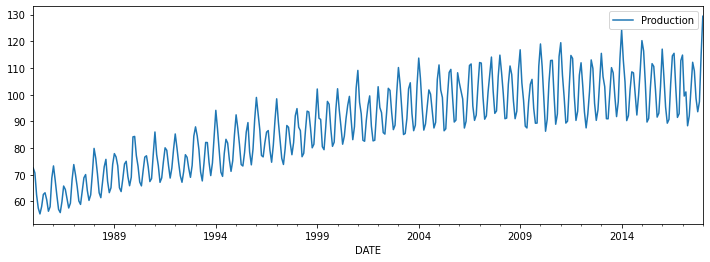

In [19]:
data.plot(figsize=(12,4))
plt.show()

In [20]:
from pylab import rcParams
import statsmodels.api as sm

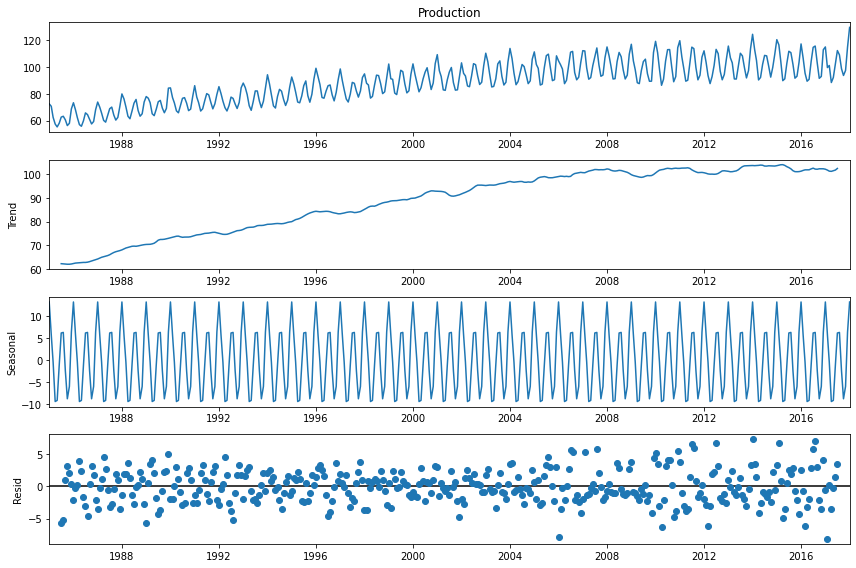

In [21]:
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Production)
fig = decomposition.plot()
plt.show()

The above plot indicates that there is a trend in the time series.

In [22]:
train_len = 360
train=data[0:train_len]
test=data[train_len:] 
print("Training set: ", train.shape)
print("Testing set: ", test.shape)

Training set:  (360, 1)
Testing set:  (37, 1)


In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [25]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
n_months = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_months, batch_size=1)

In [28]:
import tensorflow as tf

In [29]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', input_shape=(n_months, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(generator, epochs=10)

Epoch 1/10
348/348 [==============================] - 4s 7ms/step - loss: 0.0239
Epoch 2/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0133
Epoch 3/10
348/348 [==============================] - 3s 8ms/step - loss: 0.0108
Epoch 4/10
348/348 [==============================] - 3s 9ms/step - loss: 0.0069
Epoch 5/10
348/348 [==============================] - 6s 17ms/step - loss: 0.0048
Epoch 6/10
348/348 [==============================] - 4s 10ms/step - loss: 0.0044
Epoch 7/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0028
Epoch 8/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0028
Epoch 9/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0027
Epoch 10/10
348/348 [==============================] - 2s 7ms/step - loss: 0.0024


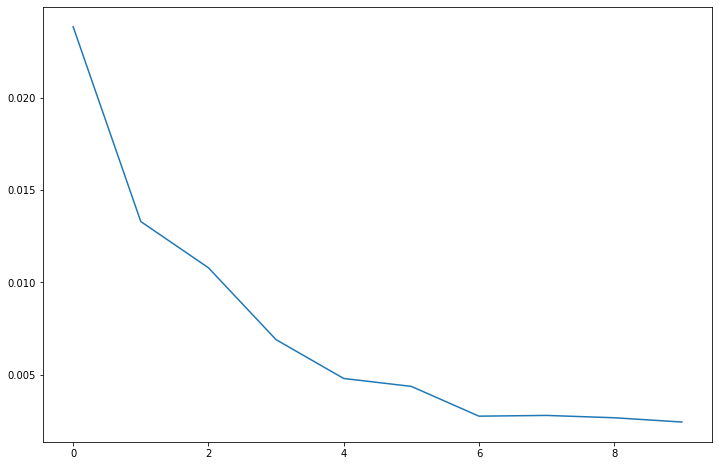

In [31]:
plt.plot(history.history['loss'])
plt.show()

In [32]:
temp = scaled_train[-n_months:]
temp = temp.reshape((1, n_months, 1))
model.predict(temp)

1/1 [==============================] - 0s 218ms/step


array([[0.9191786]], dtype=float32)

In [33]:
test_predictions = []
last_batch = scaled_train[-n_months:]
current_batch = last_batch.reshape((1, n_months, 1))
for i in range((test.shape[0])):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

1/1 [==============================] - 0s 22ms/step


In [34]:
test['LSTM_Predictions'] = scaler.inverse_transform(test_predictions)

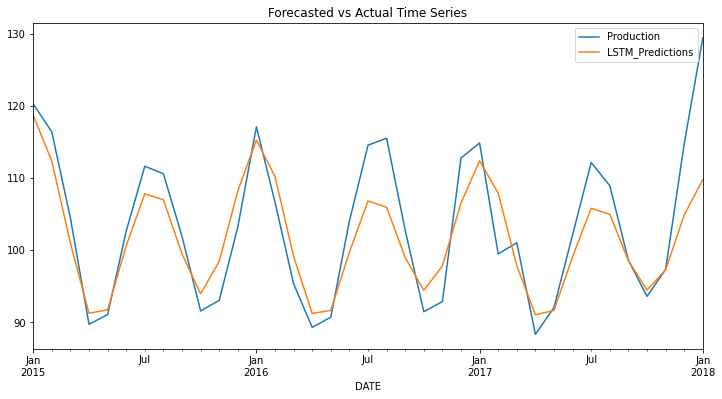

In [35]:
test.plot(figsize=(12,6))
plt.title("Forecasted vs Actual Time Series")
plt.show()

In [36]:
test.head(10)

,Production,LSTM_Predictions
DATE,,
2015-01-01,120.2696,118.683089
2015-02-01,116.3788,112.350078
2015-03-01,104.4706,100.993131
2015-04-01,89.7461,91.277914
2015-05-01,91.0930,91.750332
2015-06-01,102.6495,100.630142
2015-07-01,111.6354,107.810005
2015-08-01,110.5925,106.987139
2015-09-01,101.9204,99.507265
